# Analyze Constant Wavelength Dataset

## Summary
* read data
* apply corrections
* extract middle spectrum
* determine wavelength shift by comparing middle spectrum to reference spectrum
* apply wavelength shift
* plot the "constant" wavelengths vs. reference spectrum
* plot intensity vs. time

## Prelimiaries

In [216]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
%matplotlib inline

from astropy.io import ascii    
from astropy.table import Table, Column, vstack
import numpy as np
import matplotlib.pyplot as plt
from lasp import *

from scipy.optimize import curve_fit

## Read data

In [218]:
d = readDatasetByName( 'ConstantWavelength')
cleanTelemetry(d)
addSpectrum( d, sort=False, darkCorrection=True, dopplerCorrection=True, distanceCorrection=True, verbose=True)

g_min= 95388.0991718 g_max= 107214.099172
wavelength_min= 174.974870353 Wavelength_max= 190.00013491


## Plot grating position

This confirms we're looking at the correct dataset.

<function matplotlib.pyplot.show>

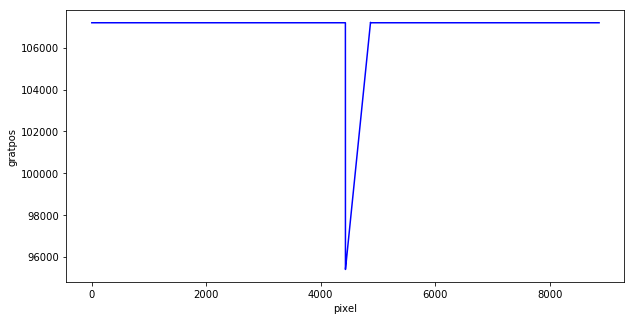

In [219]:
plt.figure(figsize=(10,5))
plt.plot( d['instrumentTelemetry']['gratPos'], 'b')
plt.xlabel( "pixel")
plt.ylabel( "gratpos")
plt.show

## Plot spectrum

<function matplotlib.pyplot.show>

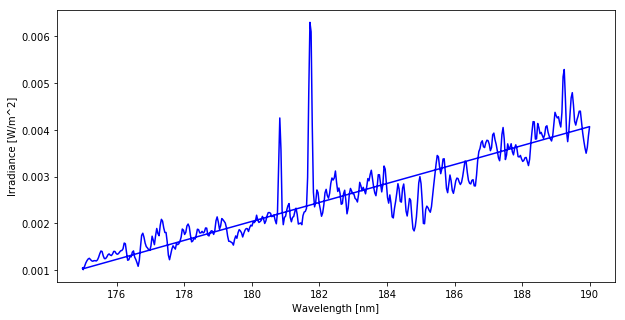

In [220]:
plt.figure(figsize=(10,5))
plt.plot( d['spectrum']['wavelength(nm)'], d['spectrum']['irradiance (watts/m^2)'], 'b')
plt.xlabel( "Wavelength [nm]")
plt.ylabel( "Irradiance [W/m^2]")
plt.show

## Plot wavelength

<function matplotlib.pyplot.show>

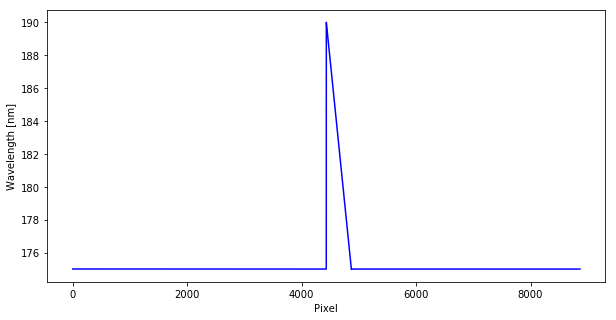

In [221]:
plt.figure(figsize=(10,5))
plt.plot( d['spectrum']['wavelength(nm)'], 'b')
plt.ylabel( "Wavelength [nm]")
plt.xlabel( "Pixel")
plt.show

## Define a function to split the spectrum
We do this by working inward from each end to locate the first point at which the grating position changes.

In [222]:
def splitConstant( d, verbose=False):
    '''
    Given a dataset object, return the endpoints of the non-constant range as a set of timestamps.
    '''
    
    # create shortcuts to arrays...
    g = d['instrumentTelemetry']['gratPos']

    # get the starting grating position and time...
    w0 = g[0]
    i0 = 0
    
    # locate first non-matching data point...
    buf = np.where( g != w0)
    good = buf[0]
    i1 = good[0]
    
    # get the ending grating position and time...
    w3 = g[-1]
    i3 = -1
    
    # locate last non-matching data point...
    buf = np.where( g != w3)
    good = buf[0]
    i2 = good[-1]
    
    # optional feedback...
    if verbose:
        print 'w3=', w3
        print g
    
    return i0, i1, i2, i3

## Execute the routine to locate the transitions from constant to non-constant

In [223]:
# run the routine...
indices = list(splitConstant(d))

w = d['spectrum']['wavelength(nm)']
x = np.arange(0,len(w),1)

# convert the list of indices to numpy arrays of indices...
wPoints = w[indices]
xPoints = x[indices]

print indices
print xPoints

[0, 4432, 4870, -1]
[   0 4432 4870 8864]


## Show dividing points
Red markers in plot show transition points from constant to non-constant wavelength

<function matplotlib.pyplot.show>

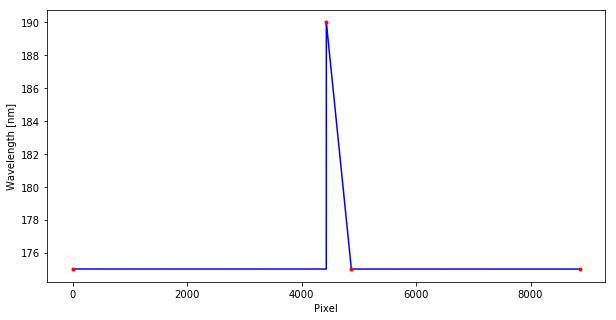

In [224]:
plt.figure(figsize=(10,5))
plt.plot( x, w, 'b', xPoints, wPoints, 'r.')
plt.ylabel( "Wavelength [nm]")
plt.xlabel( "Pixel")
plt.show

## Extract middle spectrum

In [225]:
# get times corresponding to the endpoints...
t = d['instrumentTelemetry']['microsecondsSinceGpsEpoch'][indices]
t1 = t[1]
t2 = t[2]

# re-extract spectrum between these timestamps...
dMid = sliceDatasetByTime( d, t1, t2)
cleanTelemetry(dMid)
addSpectrum( dMid, sort=True, darkCorrection=True, dopplerCorrection=True, distanceCorrection=True, verbose=False)

## Read reference spectrum

In [226]:
indir = '../laspCodingTestDataFiles/'
inFile = indir + 'referenceSpectrum.txt'
dRef = ascii.read( inFile)

## Compare middle spectrum vs. reference spectrum

<function matplotlib.pyplot.show>

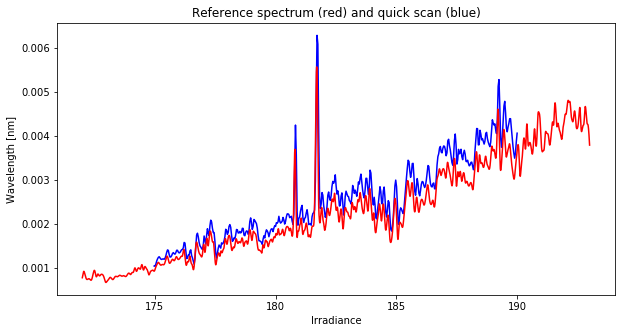

In [227]:
plt.figure(figsize=(10,5))
plt.plot( dMid['spectrum']['wavelength(nm)'], dMid['spectrum']['irradiance (watts/m^2)'], 'b', 
          dRef['wavelength(nm)'], dRef['irradiance (watts/m^2)'], 'r')
plt.ylabel( "Wavelength [nm]")
plt.xlabel( "Irradiance")
plt.title( "Reference spectrum (red) and quick scan (blue)")
plt.show

## Measure grating error
Fit Gaussians to an emission feature to determine wavelength offset between observed and reference spectra

xc1= 181.701359
xc2= 181.728941103
dx= -0.0275821030392


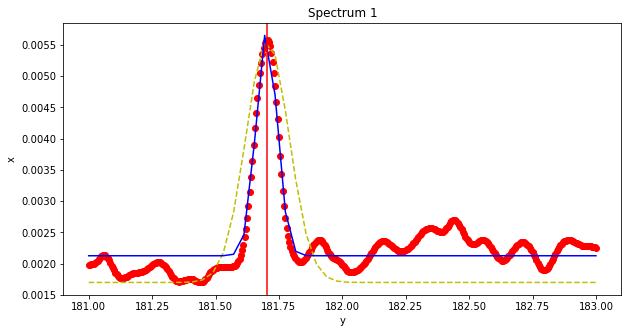

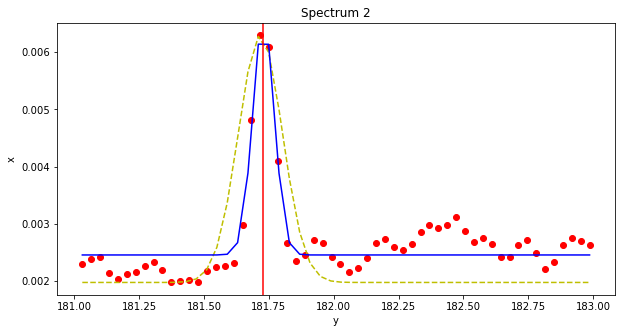

In [228]:
# define wavelength range of interest...
wMin = 181.
wMax = 183.

# perform Gaussian fit (see routine in lasp.py)...
dw = getWavelengthShift( dRef['wavelength(nm)'], dRef['irradiance (watts/m^2)'],
                    dMid['spectrum']['wavelength(nm)'], dMid['spectrum']['irradiance (watts/m^2)'],
                    wMin, wMax)

## Confirm mis-alignment of observed and reference spectra

<function matplotlib.pyplot.show>

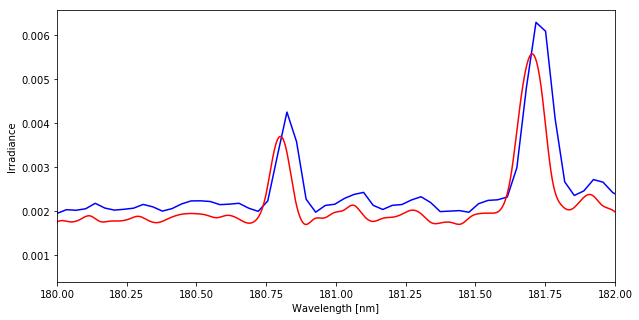

In [229]:
plt.figure(figsize=(10,5))
plt.plot( dMid['spectrum']['wavelength(nm)'], dMid['spectrum']['irradiance (watts/m^2)'], 'b', 
          dRef['wavelength(nm)'], dRef['irradiance (watts/m^2)'], 'r')
plt.xlabel( "Wavelength [nm]")
plt.ylabel( "Irradiance")
plt.xlim( 180., 182.)
plt.show

## Apply wavelength offset to align observed spectrum with reference

In [230]:
dMid['spectrum']['wavelength(nm)'] += dw

## Confirm alignment of observed and reference spectra

<function matplotlib.pyplot.show>

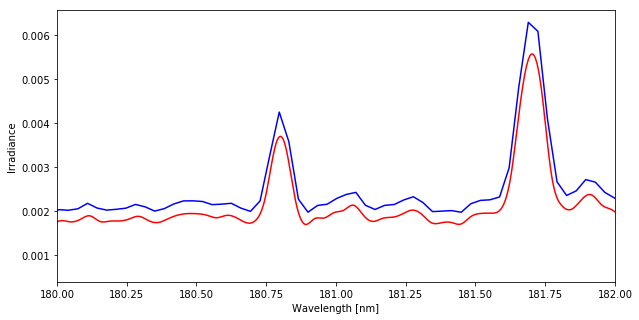

In [231]:
plt.figure(figsize=(10,5))
plt.plot( dMid['spectrum']['wavelength(nm)'], dMid['spectrum']['irradiance (watts/m^2)'], 'b', 
          dRef['wavelength(nm)'], dRef['irradiance (watts/m^2)'], 'r')
plt.xlabel( "Wavelength [nm]")
plt.ylabel( "Irradiance")
plt.xlim( 180., 182.)
plt.show

## Read "left" constant-wavelength dataset

In [232]:
# get times corresponding to the endpoints...
i0 = indices[0] # first data point
i1 = indices[1]-1 # choose the last point before the middle scan

# use these indices to get the corresponding times...
t0,t1 = d['instrumentTelemetry']['microsecondsSinceGpsEpoch'][[i0,i1]]
print t0,t1

9.4340761423e+14 9.4340982973e+14


In [233]:
# extract spectrum between these timestamps...
dLeft = sliceDatasetByTime( d, t0, t1)
cleanTelemetry(dLeft)
addSpectrum( dLeft, sort=False, darkCorrection=True, dopplerCorrection=True, distanceCorrection=True, verbose=False)

## Read "right" constant-wavelength dataset

In [234]:
# get times corresponding to the endpoints...
i0 = indices[2]+1 # first data point after middle
i1 = indices[3]   # last data point

# use these indices to get the corresponding times...
t0,t1 = d['instrumentTelemetry']['microsecondsSinceGpsEpoch'][[i0,i1]]
print t0,t1

9.4341004973e+14 9.4341204623e+14


In [235]:
# extract spectrum between these timestamps...
dRight = sliceDatasetByTime( d, t0, t1)
cleanTelemetry(dRight)
addSpectrum( dRight, sort=False, darkCorrection=True, dopplerCorrection=True, distanceCorrection=True, verbose=False)

## Combine the left and right objects into a single "combo" object

In [236]:
# allocate a new dict object...
dCombo = dict()

# iterate over tables...
for k in dLeft.keys():
    dCombo[k] = vstack( [dLeft[k], dRight[k]], join_type='exact')

## Correct wavelengths using previously determined shift w.r.t. reference spectrum

In [237]:
dCombo['spectrum']['wavelength(nm)'] += dw

## Plot variation of constant-line flux with wavelength

In [238]:
# determine wavelength range observed at constant wavelength
print np.min(dCombo['spectrum']['wavelength(nm)'])
print np.max(dCombo['spectrum']['wavelength(nm)'])

174.970097765
174.97510727


<function matplotlib.pyplot.show>

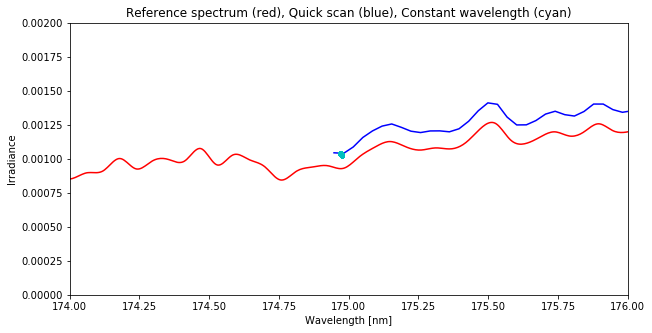

In [239]:
plt.figure(figsize=(10,5))
plt.plot( dMid['spectrum']['wavelength(nm)'], dMid['spectrum']['irradiance (watts/m^2)'], 'b', 
          dCombo['spectrum']['wavelength(nm)'], dCombo['spectrum']['irradiance (watts/m^2)'], 'c.', 
          dRef['wavelength(nm)'], dRef['irradiance (watts/m^2)'], 'r')
plt.xlabel( "Wavelength [nm]")
plt.ylabel( "Irradiance")
plt.xlim( 174., 176.)
plt.ylim( 0., 0.002)
plt.title( 'Reference spectrum (red), Quick scan (blue), Constant wavelength (cyan)')
plt.show

## Plot variation of quantities with time

<function matplotlib.pyplot.show>

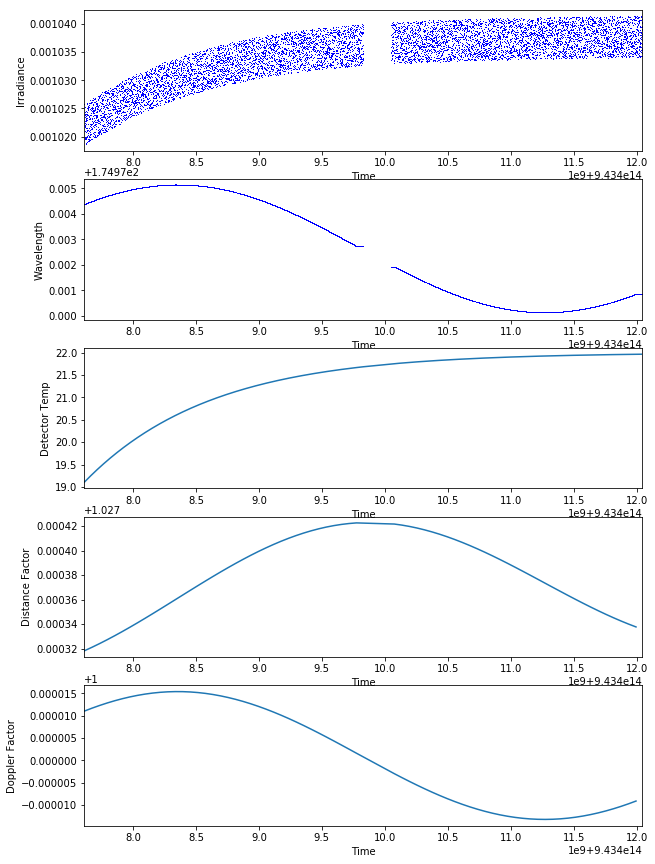

In [240]:
plt.figure(figsize=(10,15))

# get x-axis plot limits...
minTime = np.min(dCombo['spectrum']['microsecondsSinceGpsEpoch'])
maxTime = np.max(dCombo['spectrum']['microsecondsSinceGpsEpoch'])

# plot the constant-wavelength flux measurements vs. time... 
plt.subplot(5, 1, 1)
plt.plot( dCombo['spectrum']['microsecondsSinceGpsEpoch'], 
         dCombo['spectrum']['irradiance (watts/m^2)'], 'b,')
plt.xlabel( "Time")
plt.ylabel( "Irradiance")
plt.xlim( minTime, maxTime)

# plot wavelength vs. time... 
plt.subplot(5, 1, 2)
plt.plot( dCombo['spectrum']['microsecondsSinceGpsEpoch'], 
         dCombo['spectrum']['wavelength(nm)'], 'b,')
plt.xlabel( "Time")
plt.ylabel( "Wavelength")
plt.xlim( minTime, maxTime)

# plot doppler correction...
plt.subplot(5, 1, 5)
plt.plot( dCombo['distanceAndDoppler']['microsecondsSinceGpsEpoch'], 
         dCombo['distanceAndDoppler']['sunObserverDopplerFactor'])
plt.xlabel( "Time")
plt.ylabel( "Doppler Factor")
plt.xlim( minTime, maxTime)

# plot distance correction...
plt.subplot(5, 1, 4)
plt.plot( dCombo['distanceAndDoppler']['microsecondsSinceGpsEpoch'], 
         dCombo['distanceAndDoppler']['sunObserverDistanceCorrection'])
plt.xlabel( "Time")
plt.ylabel( "Distance Factor")
plt.xlim( minTime, maxTime)

# plot distance correction...
plt.subplot(5, 1, 3)
plt.plot( dCombo['detectorTemp']['microsecondsSinceGpsEpoch'], 
         dCombo['detectorTemp']['temp (C)'])
plt.xlabel( "Time")
plt.ylabel( "Detector Temp")
plt.xlim( minTime, maxTime)

plt.show

## Conclusions

* The QuickScan spectrum in the middle of the observation is broadly similar to the reference spectrum
* Observed spectra are shifted by +0.02758 nm from the reference spectra
* When observing in constant-wavelength mode, the irradiance at 175 nm was stable to about 1% over the course of the observing period
* The small variation in the irradiance seem correlated with the change in detector temperature during the observation, but not with Doppler Factor, Distance Factor, or wavelength.  This suggests that the sensitivity of the instrument is temperature dependent.